# Feature Matching

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
img1_path = os.path.join('..', '..', 'pics', 'book_frontal.JPG')
img1 = cv.imread(img1_path)
img2_path = os.path.join('..', '..', 'pics', 'book_perspective.JPG')
img2 = cv.imread(img2_path)

In [3]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

## Brute-force matching

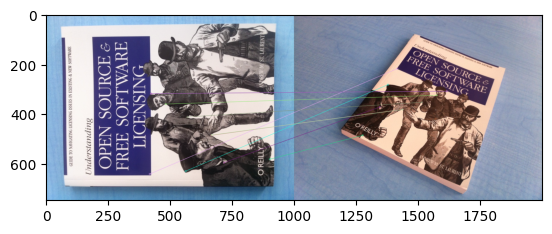

In [ ]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)

# k-NN best matches

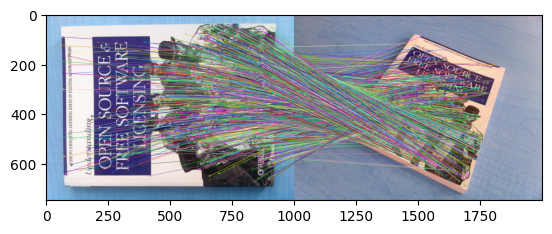

In [6]:
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
 
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)

## FLANN based Matcher

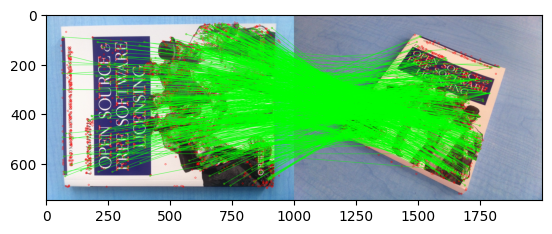

(<matplotlib.image.AxesImage at 0x19d814e6bd0>, None)

In [8]:
sift = cv.SIFT_create()
 
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
 
flann = cv.FlannBasedMatcher(index_params,search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
 
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
 
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
 
plt.imshow(img3,),plt.show()

# Feature matching and homography to find objects

In [11]:
img1_path = os.path.join('..', '..', 'pics', 'book_frontal.JPG')
img1 = cv.imread(img1_path)
img1 =cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

img2_path = os.path.join('..', '..', 'pics', 'book_perspective.JPG')
img2 = cv.imread(img2_path)
img2 =cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
 
flann = cv.FlannBasedMatcher(index_params, search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# store all the good matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [12]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
 
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
 
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

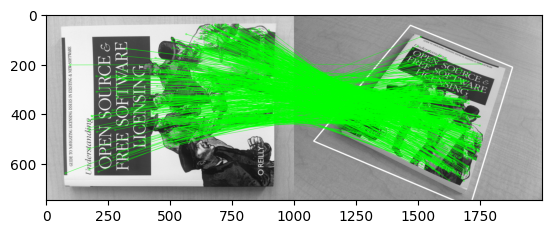

In [13]:
draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3, 'gray')